# WeGo Public Transit

#### Questions

1. How much impact does being late or too spaced out at the first stop have downstream?


2. What is the impact of the layover at the start of the trip (the difference between the first top arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

#### Read in Data

In [68]:
pip install statsmodels

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you'll have numpy 1.19.4 which is incompatible.



  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from datetime import datetime, timedelta

C:\Users\18285\anaconda3\envs\geospatial\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv', na_values= "NULL")
wego.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.5


#### Drop Null and NaN values

In [42]:
wego_drop = wego[wego['ACTUAL_ARRIVAL_TIME'] != 'NULL']
wego_drop = wego.dropna(subset=['ACTUAL_ARRIVAL_TIME'])

In [43]:
wego_drop['Hours'] = wego_drop['ACTUAL_ARRIVAL_TIME'].str[:2]
wego_drop['Hours'] = wego_drop['Hours'].str.replace(':', '', regex=True)
wego_drop['Hours'] = wego_drop['Hours'].astype(int)

<ipython-input-43-52d78353f073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['Hours'] = wego_drop['ACTUAL_ARRIVAL_TIME'].str[:2]
<ipython-input-43-52d78353f073>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wego_drop['Hours'] = wego_drop['Hours'].str.replace(':', '', regex=True)
<ipython-input-43-52d78353f073>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [44]:
values_to_drop = [24, 25]
wego_drop = wego_drop[~wego_drop['Hours'].isin(values_to_drop)]

#### Drop Null and NaN values

In [45]:
wego_drop['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego_drop['ACTUAL_ARRIVAL_TIME']).dt.time

#### Create 'seconds from midnight' to rank trips

In [46]:
wego_drop['Arrival Time (seconds)'] = wego_drop.groupby(['OPERATOR', 'DATE'])['ACTUAL_ARRIVAL_TIME'].transform(lambda x: x.apply(lambda y: y.hour * 3600 + y.minute * 60 + y.second))
wego_drop['Rank'] = wego_drop.groupby(['OPERATOR', 'DATE'])['Arrival Time (seconds)'].rank(method='first')

#### Create 'Unique Trip ID'

In [47]:
wego_drop['DATE_STR'] = wego_drop['DATE'].astype(str)
wego_drop['TRIP_ID_STR'] = wego_drop['TRIP_ID'].astype(str)

In [48]:
wego_drop['CORRECTED_TRIP_ID'] = wego_drop['DATE_STR'] + "-" + wego_drop['TRIP_ID_STR']

In [49]:
wego_drop['TRIP_RANK'] = wego_drop.groupby(['OPERATOR', 'CORRECTED_TRIP_ID'])['Arrival Time (seconds)'].rank(method='first')

In [50]:
trip_edge_eda = wego_drop[['DATE','OPERATOR','ACTUAL_ARRIVAL_TIME','CORRECTED_TRIP_ID','TRIP_EDGE','TRIP_RANK','ADHERENCE','DWELL_IN_MINS']]
trip_edge_eda.head()

,DATE,OPERATOR,ACTUAL_ARRIVAL_TIME,CORRECTED_TRIP_ID,TRIP_EDGE,TRIP_RANK,ADHERENCE,DWELL_IN_MINS
0,8/1/2023,1040,04:37:38,8/1/2023-345104,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,04:48:27,8/1/2023-345104,0,2.0,-2.450000,0.000000
2,8/1/2023,1040,04:54:56,8/1/2023-345104,0,3.0,-0.933333,0.000000
3,8/1/2023,1040,05:03:43,8/1/2023-345104,2,4.0,6.283333,0.000000
4,8/1/2023,1040,05:03:43,8/1/2023-345105,1,1.0,-1.583333,12.866666


#### Create a function that groups all first stop adherence values

In [51]:
def find_min_rank_adherence(trip_edge_eda):
    # Group by 'Trip ID' and find the row with the minimum 'Rank'
    min_rank_adherence_df = trip_edge_eda.loc[trip_edge_eda.groupby('CORRECTED_TRIP_ID')['TRIP_RANK'].idxmin()]
    
    return min_rank_adherence_df

min_rank_adherence = find_min_rank_adherence(trip_edge_eda)

#### Create a function that groups all last stop adherence values

In [52]:
def find_max_rank_adherence(trip_edge_eda):
    # Group by 'Trip ID' and find the row with the minimum 'Rank'
    max_rank_adherence_df = trip_edge_eda.loc[trip_edge_eda.groupby('CORRECTED_TRIP_ID')['TRIP_RANK'].idxmax()]
    
    return max_rank_adherence_df

max_rank_adherence = find_max_rank_adherence(trip_edge_eda)

#### New dataframe with column for first and last stop adherence

In [54]:
min_max_rank_adherence = pd.merge(max_rank_adherence, min_rank_adherence, on=['CORRECTED_TRIP_ID'], how='inner')

In [55]:
min_max_rank_adherence.drop(columns=['DATE_y','OPERATOR_y','ACTUAL_ARRIVAL_TIME_y','DWELL_IN_MINS_x','ACTUAL_ARRIVAL_TIME_x'], axis = 1, inplace=True)

In [56]:
min_max_rank_adherence = min_max_rank_adherence.rename(columns={'DATE_x': 'DATE', 'OPERATOR_x': 'OPERATOR','TRIP_EDGE_x': 'MIN_TRIP_EDGE','TRIP_RANK_x': 'MIN_TRIP_RANK','ADHERENCE_x':'MIN_ADHERENCE','DWELL_IN_MINS_y':'FIRST_DWELL_MIN','TRIP_EDGE_y':'MAX_TRIP_EDGE','TRIP_RANK_y':'MAX_TRIP_RANK','ADHERENCE_y':'MAX_ADHERENCE'})

In [75]:
min_max_rank_adherence.head()

,DATE,OPERATOR,CORRECTED_TRIP_ID,MIN_TRIP_EDGE,MIN_TRIP_RANK,MIN_ADHERENCE,MAX_TRIP_EDGE,MAX_TRIP_RANK,MAX_ADHERENCE,FIRST_DWELL_MIN
0,8/1/2023,1040,8/1/2023-345104,2,4.0,6.283333,1,1.0,-2.133333,6.500000
1,8/1/2023,1040,8/1/2023-345105,2,3.0,1.500000,1,1.0,-1.583333,12.866666
2,8/1/2023,1040,8/1/2023-345106,2,4.0,4.483333,1,1.0,-1.716666,13.216666
3,8/1/2023,1040,8/1/2023-345107,2,3.0,4.016666,1,1.0,-1.316666,10.800000
4,8/1/2023,1040,8/1/2023-345108,2,4.0,4.183333,1,1.0,-1.516666,12.533333


#### Correlation and Scatterplots

In [60]:
min_max_rank_adherence[['FIRST_DWELL_MIN', 'MAX_ADHERENCE']].corr()

,FIRST_DWELL_MIN,MAX_ADHERENCE
FIRST_DWELL_MIN,1.000000,-0.490291
MAX_ADHERENCE,-0.490291,1.000000


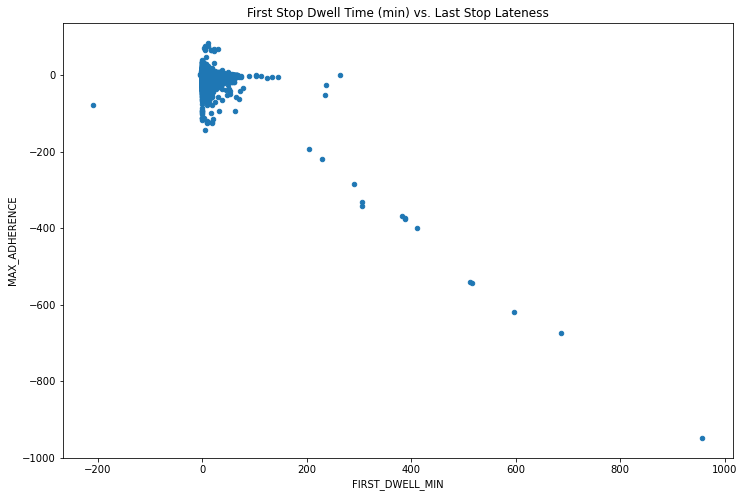

In [61]:
min_max_rank_adherence.plot(kind = 'scatter', x = 'FIRST_DWELL_MIN', y = 'MAX_ADHERENCE', figsize = (12,8))
plt.title('First Stop Dwell Time (min) vs. Last Stop Lateness');

In [62]:
min_max_rank_adherence[['MIN_ADHERENCE', 'MAX_ADHERENCE']].corr()

,MIN_ADHERENCE,MAX_ADHERENCE
MIN_ADHERENCE,1.000000,0.729451
MAX_ADHERENCE,0.729451,1.000000


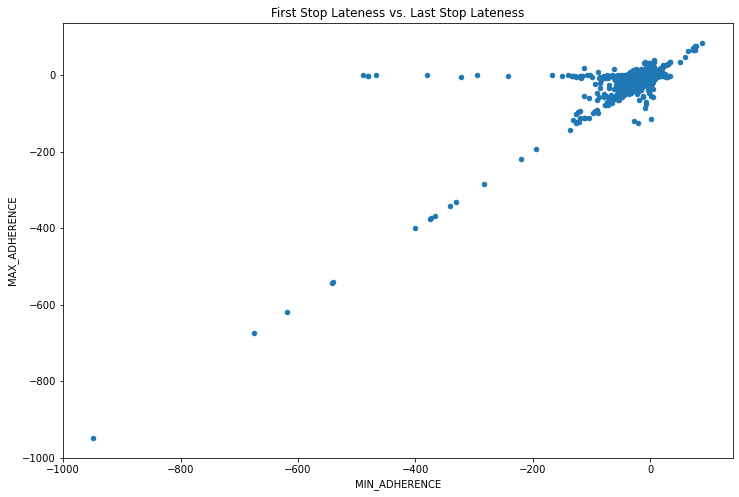

In [63]:
min_max_rank_adherence.plot(kind = 'scatter', x = 'MIN_ADHERENCE', y = 'MAX_ADHERENCE', figsize = (12,8))
plt.title('First Stop Lateness vs. Last Stop Lateness');

#### Linear Regression

In [70]:
lm = smf.ols('FIRST_DWELL_MIN ~ MAX_ADHERENCE', data = min_max_rank_adherence).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        FIRST_DWELL_MIN   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                 2.090e+04
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:47:24   Log-Likelihood:            -2.4551e+05
No. Observations:               66055   AIC:                         4.910e+05
Df Residuals:                   66053   BIC:                         4.910e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.6720      0.041    286.099      0.000      11.592      11.752
MAX_ADHERENCE    -0.6689      0.005   -144.579      0.000      -0.678      -0.660
==============================================================================
Omnibus:                    37998.272   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6042885.512
Skew:                           1.742   Prob(JB):                         0.00
Kurtosis:                      49.727   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
lm = smf.ols('MIN_ADHERENCE ~ MAX_ADHERENCE', data = min_max_rank_adherence).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MIN_ADHERENCE   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                 7.512e+04
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:48:05   Log-Likelihood:            -2.2815e+05
No. Observations:               66055   AIC:                         4.563e+05
Df Residuals:                   66053   BIC:                         4.563e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5147      0.031     16.410      0.000       0.453       0.576
MAX_ADHERENCE     0.9749      0.004    274.073      0.000       0.968       0.982
==============================================================================
Omnibus:                   149434.548   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3581471180.315
Skew:                         -21.039   Prob(JB):                         0.00
Kurtosis:                    1142.955   Cond. No.                         9.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

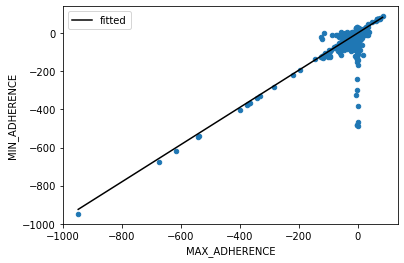

In [74]:
ax = min_max_rank_adherence.plot(x = 'MAX_ADHERENCE', y = 'MIN_ADHERENCE', kind = 'scatter')

fit_df = pd.DataFrame({
    'MAX_ADHERENCE': np.linspace(
        start = min_max_rank_adherence['MAX_ADHERENCE'].min(),
        stop = min_max_rank_adherence['MAX_ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'MAX_ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');